In [1]:
import numpy as np
from tqdm import tqdm


class UniformlyRandom:
    def __init__(self, K):
        self.K = K
        self.reset(0)

    def reset(self, T):
        self.time_step = 0
        self.cumulative_regret = np.zeros(T)


    def select_arm(self):
        return np.random.randint(self.K)

    def run(self, data):
        T = len(data)
        self.reset(T)
        cumulative_reward = 0
        reward_vector = np.zeros(self.K)
        for t in tqdm(range(T)):
            chosen_arm = self.select_arm()
            arm_log, reward_log = int(data[t][0]), data[t][1]
            reward_t = reward_log * (arm_log == chosen_arm) * self.K
            
            cumulative_reward += reward_t
            
            reward_vector[arm_log] += reward_log * self.K
            self.cumulative_regret[t] = np.max(reward_vector) - cumulative_reward


In [2]:
class LearningRate():
    def __init__(self, nA):
        self.nA = nA
        self.fn = lambda x: np.sqrt(np.log(self.nA) / (self.nA * self.nA * x))
        self.t = 0
    
    def step(self):
        self.t += 1
        return self.fn(self.t)

class EXP3():
    def __init__(self, K):
        self.K = K
        self.lr = LearningRate(K)
    
    def run(self, data): #0: optimal arm
        T = len(data)
        self.cumulative_regret = np.zeros(T)
        P = np.full(self.K, 1 / self.K)
        cum_loss = np.zeros(self.K)
        loss_vector = np.zeros(self.K)
        sum_l_at = 0.0

        for t in tqdm(range(T)):
            
            eta = self.lr.step()
            a_t = np.random.choice(self.K, p=P)
            # l_t = np.random.binomial(1, p=expected_losses[a_t])
            a_log, l_log = int(data[t][0]), data[t][1]
            
            l_t = (a_log == a_t) * l_log * self.K
            
            l_tilde_t = l_t / P[a_t]
            cum_loss[a_t] += l_tilde_t

            sum_l_at += l_t
            loss_vector[a_log] += l_log * self.K

            self.cumulative_regret[t] = sum_l_at - np.min(loss_vector)
            
            min_cum_loss = cum_loss - np.min(cum_loss) #numerical stability
            exp = np.exp(-eta * min_cum_loss)
            P = exp / np.sum(exp)

    def __repr__(self):
        return "EXP3"

In [3]:
# import numpy as np
# from tqdm import tqdm

# class LearningRate:
#     def __init__(self, nA):
#         self.nA = nA
#         self.fn = lambda x: np.sqrt(np.log(nA) / (nA * x))
#         self.t = 0
    
#     def step(self):
#         self.t += 1
#         return self.fn(self.t)

# class EXP3:
#     def __init__(self, K):
#         self.K = K
#         self.lr = LearningRate(K)
#         self.reset(0)

#     def reset(self, T):
#         self.probabilities = np.full(self.K, 1 / self.K)
#         self.cum_loss = np.zeros(self.K)
#         self.cumulative_regret = None
#         self.time_step = 0
#         self.eta = self.lr.step()  # Initial learning rate
#         self.cumulative_regret = np.zeros(T)

#     def update(self, chosen_arm, reward):
#         l_tilde = reward / self.probabilities[chosen_arm]
#         self.cum_loss[chosen_arm] += l_tilde

#         # Update probabilities
#         min_cum_loss = self.cum_loss - np.min(self.cum_loss)  # For numerical stability
#         exp_term = np.exp(-self.eta * min_cum_loss)
#         self.probabilities = exp_term / np.sum(exp_term)
        
#         self.time_step += 1
#         self.eta = self.lr.step()  # Update learning rate for the next step

#     def select_arm(self):
#         return np.random.choice(self.K, p=self.probabilities)

#     def run(self, data):
#         T = len(data)
#         self.reset(T)
#         cumulative_reward = 0
#         reward_vector = np.zeros(self.K)
#         for t in tqdm(range(T)):
#             chosen_arm = self.select_arm()
#             arm_log, reward_log = int(data[t][0]), data[t][1]
#             reward_t = reward_log * (arm_log == chosen_arm) * self.K
#             self.update(chosen_arm, reward_t)
            
#             cumulative_reward += reward_t
            
#             reward_vector[arm_log] += reward_log * self.K
#             self.cumulative_regret[t] = np.max(reward_vector) - cumulative_reward

#     def __repr__(self):
#         return f"EXP3(K={self.K})"


In [4]:
import numpy as np
from tqdm import tqdm

class UCB1:
    def __init__(self, K):
        self.K = K  # Number of arms
        self.counts = np.zeros(K, dtype=int)
        self.rewards = np.zeros(K, dtype=float)
        self.total_pulls = 0
        self.cumulative_regret = None

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1 
        self.rewards[chosen_arm] += reward
        self.total_pulls += 1

    def calculate_ucb(self):            
        mean_reward = self.rewards / self.counts
        confidence_interval = self.K * np.sqrt(np.log(self.total_pulls) / self.counts)
        return mean_reward + confidence_interval

    def select_arm(self) -> int:
        ucb_values = self.calculate_ucb()
        return np.random.choice(np.flatnonzero(ucb_values == ucb_values.min()))

    def reset(self, T):
        self.counts = np.zeros(self.K, dtype=int)
        self.rewards = np.zeros(self.K, dtype=float)
        self.total_pulls = 0
        self.cumulative_regret = np.zeros(T)

    def __repr__(self) -> str:
        return f"UCB1(K={self.K})"

    def run(self, data):
        T = len(data)
        
        self.reset(T)
        cumulative_reward = 0
        reward_vector = np.zeros(self.K)
        for t in tqdm(range(T)):
            chosen_arm = self.select_arm() if t >= self.K else t
            arm_log, reward_log = int(data[t][0]), data[t][1]
            reward_t = reward_log * (arm_log == chosen_arm) * self.K

            self.update(chosen_arm, reward_t)

            # Update cumulative loss and calculate regret
            cumulative_reward += reward_t
            reward_vector[arm_log] += reward_log * self.K
            self.cumulative_regret[t] = np.max(reward_vector) - cumulative_reward

In [5]:
def run_experiments(algorithm_cls, K, data,num_runs=10):
    regrets = []
    for _ in tqdm(range(num_runs)):
        algorithm = algorithm_cls(K=K)
        algorithm.run(data)
        regrets.append(algorithm.cumulative_regret)
    return np.array(regrets)

In [6]:
from matplotlib import pyplot as plt

def plot_combined_regret(ucb_regrets, exp3_regrets, title='Cumulative Regret over Time'):
    mean_ucb = np.mean(ucb_regrets, axis=0)
    std_ucb = np.std(ucb_regrets, axis=0)

    mean_exp3 = np.mean(exp3_regrets, axis=0)
    std_exp3 = np.std(exp3_regrets, axis=0)
    
    plt.figure(figsize=(12, 8))

    # Plot UCB1
    plt.plot(mean_ucb, label='UCB1 Mean Cumulative Regret')
    plt.fill_between(range(len(mean_ucb)), mean_ucb - std_ucb, mean_ucb + std_ucb, color='blue', alpha=0.2)

    # Plot EXP3
    plt.plot(mean_exp3, label='EXP3 Mean Cumulative Regret')
    plt.fill_between(range(len(mean_exp3)), mean_exp3 - std_exp3, mean_exp3 + std_exp3, color='red', alpha=0.2)
    
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_regrets_and_bound(ucb_regrets, exp3_regrets, uniform_random_regrets, K, T, title='Regret over Time with Theoretical Bounds'):
    # Compute means and standard deviations
    mean_ucb = np.mean(ucb_regrets, axis=0)
    std_ucb = np.std(ucb_regrets, axis=0)
    
    mean_exp3 = np.mean(exp3_regrets, axis=0)
    std_exp3 = np.std(exp3_regrets, axis=0)
    
    mean_ur = np.mean(uniform_random_regrets, axis=0)
    std_ur = np.std(uniform_random_regrets, axis=0)
    
    # Time steps
    time_steps = np.arange(T)

    # Plotting
    plt.figure(figsize=(15, 8))
    plt.plot(mean_ucb, label='Modified UCB1')
    plt.fill_between(time_steps, mean_ucb - std_ucb, mean_ucb + std_ucb, alpha=0.2)
    
    plt.plot(mean_exp3, label='Modified EXP3')
    plt.fill_between(time_steps, mean_exp3 - std_exp3, mean_exp3 + std_exp3, alpha=0.2)
    
    plt.plot(mean_ur, label='Uniformly Random')
    plt.fill_between(time_steps, mean_ur - std_ur, mean_ur + std_ur, alpha=0.2)

    # Theoretical regret bound for EXP3 for all t <= T
    ts = np.arange(T)
    exp3_bound = np.sqrt(2 * K * ts *np.log(K))
    plt.plot(exp3_bound, label='EXP3 Theoretical Upper Bound', linestyle='--')

    plt.xlabel('Time step')
    plt.ylabel('Cumulative Regret')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{title}.pdf')
    plt.show()



In [7]:
def get_total_rewards_by_arm(data, K):
    total_rewards = np.zeros(K)
    for arm, reward in data:
        total_rewards[int(arm)] += reward
    return total_rewards

In [8]:
# Create a function that filters the data for the specified arms
def filter_data_for_arms(data, arms):
    arm_to_new_index = {old_index: new_index for new_index, old_index in enumerate(arms)}

    # Apply the mapping and filter the data simultaneously
    filtered_and_remapped_data = np.array([
        [arm_to_new_index.get(d[0]), d[1]] for d in data if d[0] in arms
    ])

    return filtered_and_remapped_data

In [9]:
K = 16  # Number of arms
T = 701682  # Time horizon
data = np.loadtxt('data_preprocessed_features', usecols=range(2))

# Get total rewards until time T
total_rewards = get_total_rewards_by_arm(data[:T], K)

# Sort the arms based on total rewards and pick the best, median, and worst
sorted_arms = np.argsort(total_rewards)
best_arm = sorted_arms[-1]
worst_arm = sorted_arms[0]
median_arms = sorted_arms[K // 2 - 1: K // 2 + 1] 

In [10]:
subsets = {
    'all_arms': np.arange(K),
    'best_and_worst': [best_arm, worst_arm],
    'best_and_two_worst': [best_arm] + sorted_arms[:2].tolist(),
    'best_and_three_worst': [best_arm] + sorted_arms[:3].tolist(),
    'best_median_worst': [best_arm, median_arms[0], worst_arm]  
}

Running experiments for subset: all_arms


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


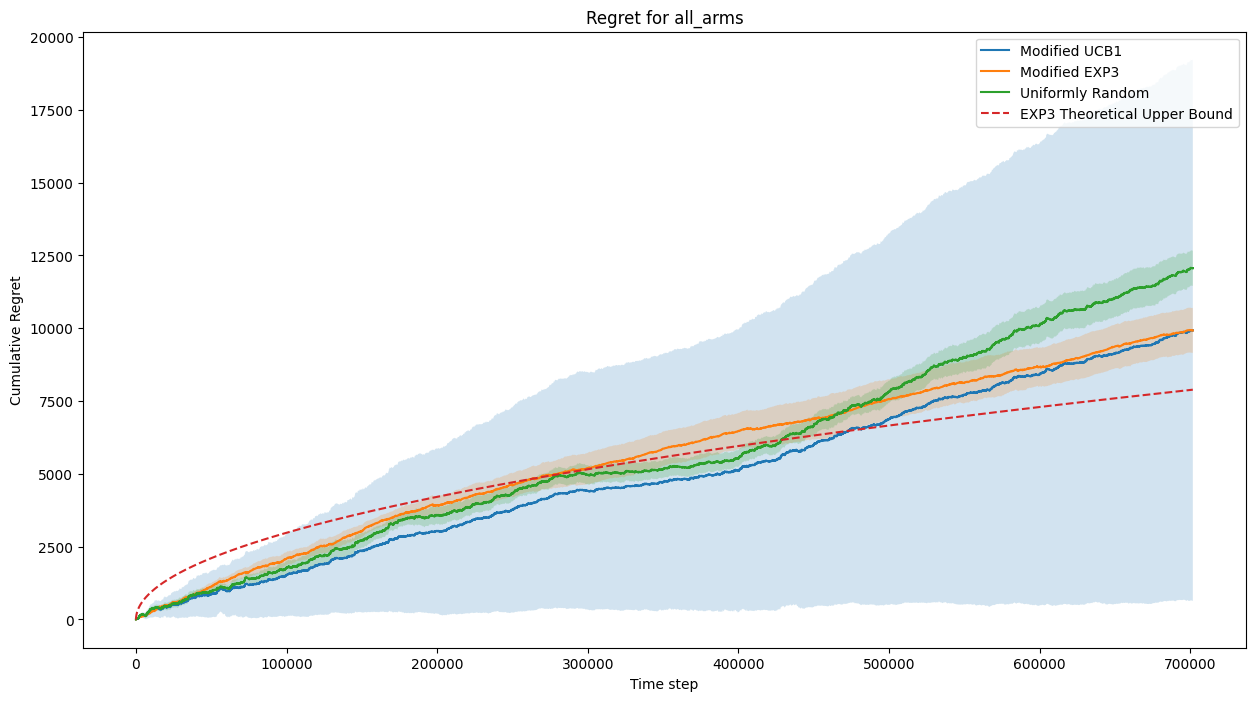

Running experiments for subset: best_and_worst


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


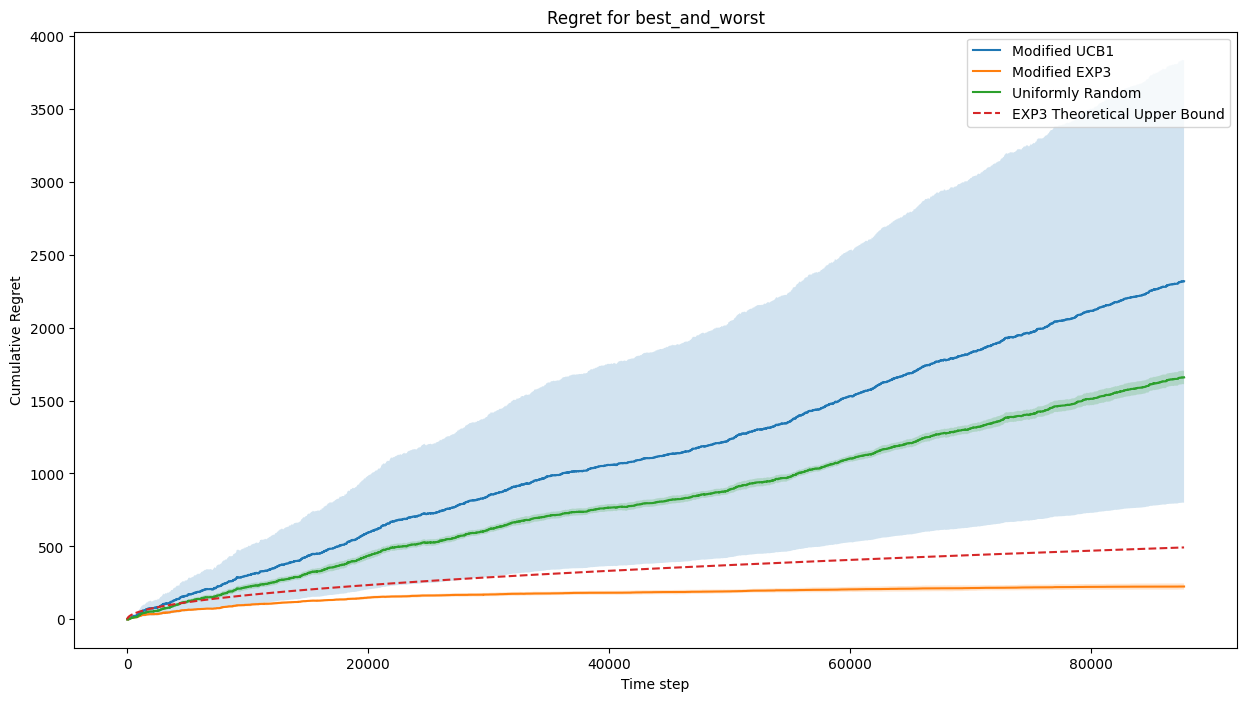

Running experiments for subset: best_and_two_worst


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


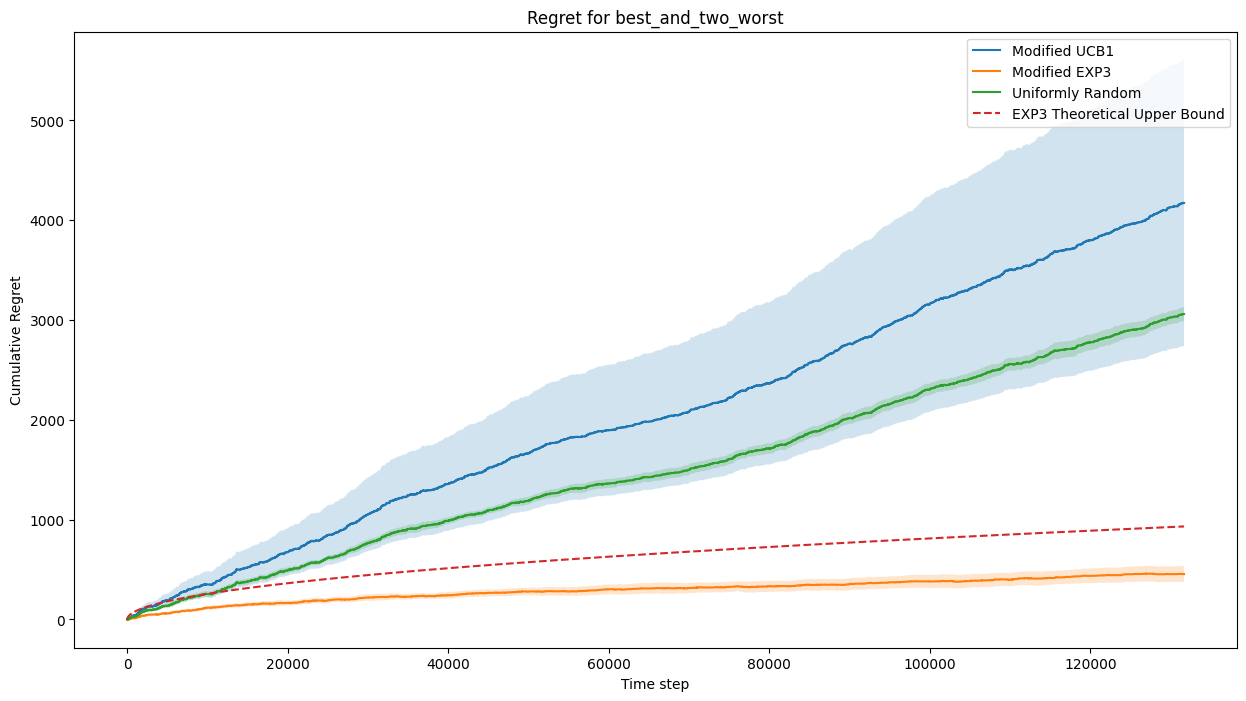

Running experiments for subset: best_and_three_worst


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


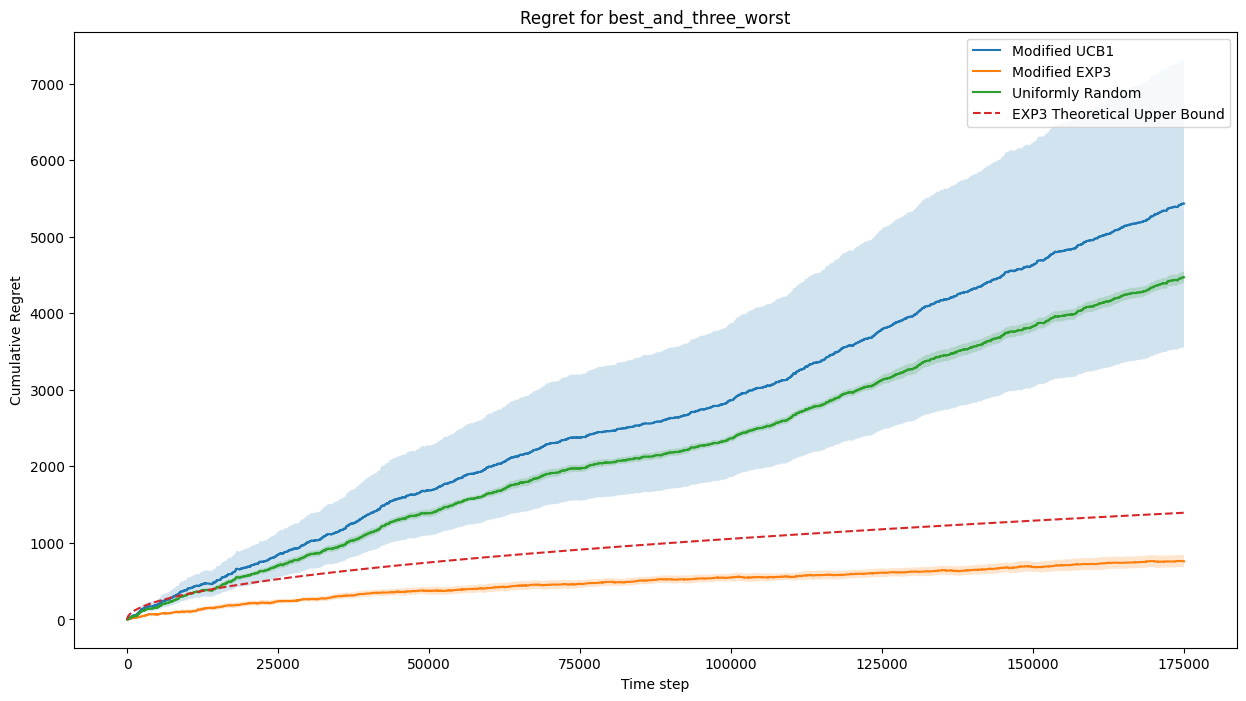

Running experiments for subset: best_median_worst


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


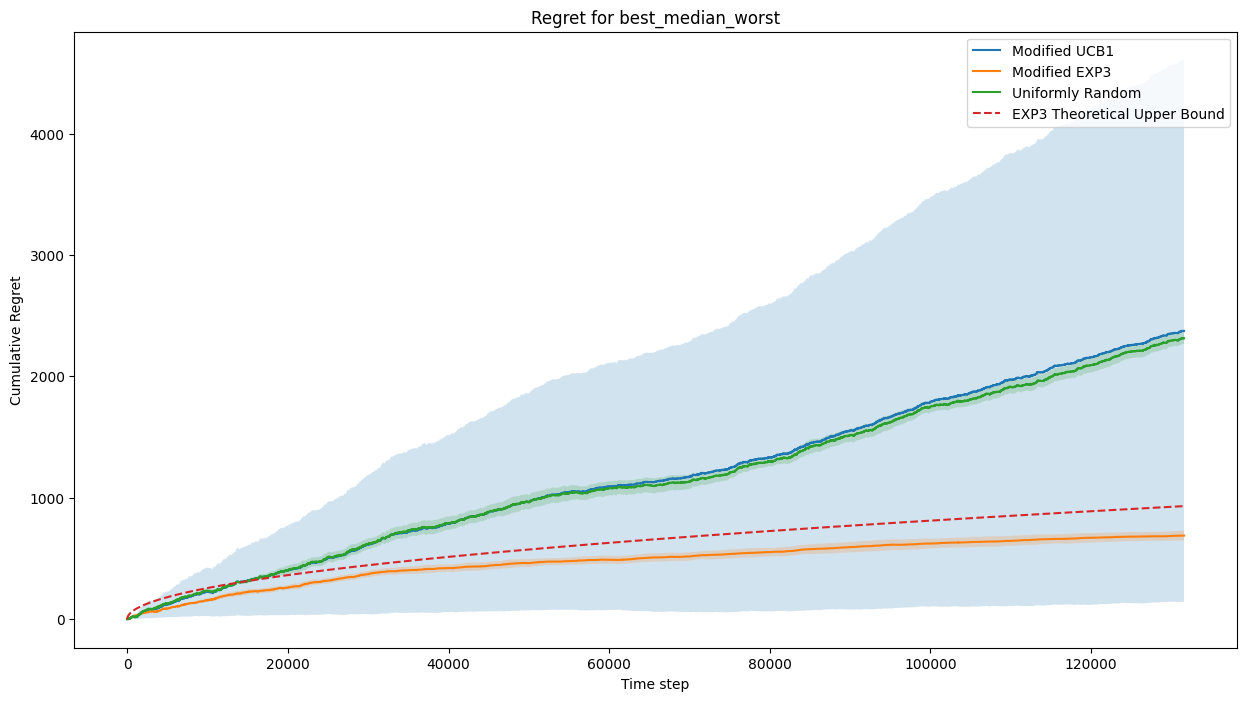

In [11]:
# Run experiments for each subset
for subset_name, arms in subsets.items():
    print(f"Running experiments for subset: {subset_name}")
    subset_data = filter_data_for_arms(data, arms)
    ucb_regrets = run_experiments(UCB1, len(arms), subset_data, num_runs=10)
    exp3_regrets = run_experiments(EXP3, len(arms), subset_data, num_runs=10)
    ur_regrets = run_experiments(UniformlyRandom, len(arms), subset_data, num_runs=10)
    plot_regrets_and_bound(ucb_regrets, exp3_regrets, ur_regrets, len(arms), len(subset_data), title=f'Regret for {subset_name}')